## The Aim of This Project Is To Predict The Gender Of An Artist Based On The Lyrics Of   The Artist's Song

In [149]:
import re
import os
import nltk
import ftfy
import ast
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
from afinn import Afinn
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from preprocessing import *

from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


%matplotlib inline

### Data Collection
- BeautifulSoup is used to scrape names of artists from the billboard website
- These names are used in the Musixmatch and lyricsgenius APIs to download lyrics
- Script used is scraper.py
- Seperate files combined in combine.py

### Data Preprocessing

- Script used is preprocessing.py

### Feature Extraction

In [150]:
af = Afinn()
class Artist:
    def __init__(self, obj):
        self.gender = obj['gender']
        self.lyrics = ""
        self.tokens = []
        self.pos_list = []
        self.num_tokens = 0
        self.adj_pos_present = 0
        self.pp_pos_present = 0
        self.vb_pos_present = 0
        self.pos_fql = Counter()
        self.bigrams = Counter()
        self.trigrams = Counter()
        self.char_trigrams = Counter()
        self.char_fourgrams = Counter()
        self.tokens_fql = Counter()
        self.pp_pos_fql = Counter()
        self.adj_pos_fql = Counter()
        self.vb_pos_fql = Counter()
        self.sent_score = 0
        self.sent = ""

        
    tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") 
    def tokenise(self, text):
        return tokenise_re.findall(text)

    def extract_features(self, track):
        self.lyrics += track
        p_lyrics = replace_apostrophe(track) 
        p_lyrics = preprocess(p_lyrics) 
        self.lyrics = p_lyrics
        tokens = self.tokenise(p_lyrics)
        tokens = remove_stopwords(tokens)
        self.num_tokens += len(tokens)
        self.tokens.extend(tokens)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens)
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        self.bigrams.update(self.ngrams(tokens, 2))
        self.trigrams.update(self.ngrams(tokens, 3))
        self.char_trigrams.update(self.char_ngrams(tokens, 3))
        self.char_fourgrams.update(self.char_ngrams(tokens, 4))
        self.pp_pos_fql.update(self.adjectives(self.pos_list))
        self.adj_pos_fql.update(self.personal_pronoun(self.pos_list))
        self.vb_pos_fql.update(self.verb(self.pos_list))
        self.sent_score = self.sentiment_score(self.lyrics)
        self.sent = self.sentiment(self.sent_score)

        
    #lexical features 
    def ngrams(self, tokens, n, sep = "_", buffer="^"):
        buffered = [buffer] * (n-1) + tokens + [buffer] * (n-1) 
        return [sep.join(buffered[i:i+n]) for i in range(len(buffered)-n+1)]
    
    def char_ngrams(self, tokens, n,buffer="^"):
        char_list = []
        
        for token in tokens:
            for char in token:
                char_list.append(char.lower())
        
        buffered = [buffer] * (n-1) + char_list + [buffer] * (n-1)
        return ["".join(buffered[i:i+n]) for i in range(len(buffered)-n+1)]
    
    def extract_features_from_lyrics(self, tracks):
        for lyrics in tracks:
            extract_features(lyrics)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens
    
    #Syntactic features: POS used adjectives, personal pronouns, verbs,
    def adjectives(self, pos_list):
        adj_pos = []
        for pos in pos_list:
            if pos == "JJ" or pos == "ADJ":
                adj_pos.append(pos)

        if len(adj_pos) == 0:
            self.adj_pos_present = 0
            return {"None present":0}
        else:
            self.adj_pos_present = len(adj_pos)
            return adj_pos
            
    def personal_pronoun(self, pos_list):
        pp_pos = []
        for pos in pos_list:
            if pos == "PRP":
                pp_pos.append(pos)
    
        if len(pp_pos) == 0:
            self.pp_pos_present = 0
            return {"None present":0}
        else:
            self.pp_pos_present = len(pp_pos)
            return pp_pos
    
    def verb(self, pos_list):
        vb_pos = []
        for pos in pos_list:
            if pos == "VB":
                vb_pos.append(pos)

        if len(vb_pos) == 0:
            self.vb_pos_present = 0
            return {"None present":0}
        else:
            self.vb_pos_present = len(vb_pos)
            return vb_pos
    
    def adj_present(self, tokens):
        count = len(self.adjectives(tokens))
        return count
    
    def pp_present(self, tokens):
        count = len(self.personal_pronoun(tokens))
        return count
    
    def vb_present(self, tokens):
        count = len(self.personal_pronoun(tokens))
        return count
    
    #sentiment lexicon using AFINN sentiment lexicon 
    def sentiment_score(self, lyrics):
        score = af.score(lyrics)
        return score
    
    def sentiment(self, score):
        sentiment = ""
        if score > 0:
            sentiment = "positive"
        elif score < 0:
            sentiment = "negative"
        else:
            sentiment = "neutral"
        return sentiment

In [151]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

#### Baseline

In [152]:
def get_bow(document):
    return document.tokens

#### Lexical features

In [153]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_bigrams(document):
    return document.bigrams

def get_trigrams(document):
    return document.trigrams

def get_char_trigrams(document):
    return document.char_trigrams

def get_char_fourgrams(document):
    return document.char_fourgrams

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file, encoder="utf-8"):
    with open(file, encoding=encoder) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) 
    return +fws_fql

#### Syntatic features

In [154]:
def get_pos_fql(document):
    return document.pos_fql

def get_adj_fql(document):
    return document.adj_pos_fql

def get_pp_fql(document):
    return document.pp_pos_fql

def get_vb_fql(document):
    return document.vb_pos_fql

#### Sentiment/opinion lexicon

In [155]:
pws = read_list("OpinionLexicon/positive-words.txt")

def get_pws_fql(document):
    pws_fql = Counter({t: document.tokens_fql[t] for t in pws})
    return +pws_fql

nws = read_list("OpinionLexicon/negative-words.txt", "ISO-8859-1")

def get_nws_fql(document):
    nws_fql = Counter({t: document.tokens_fql[t] for t in nws})
    return +nws_fql

def get_pws_stats(document):
    sum_lengths = 0
    for key, value in document.tokens_fql.items():
        sum_lengths += len(key) * value
    no_pws = len({t: document.tokens_fql[t] for t in pws})
    try:
        average = no_pws/sum_lengths
    except:
        average = 0
    return {'average': average}

def get_nws_stats(document):
    sum_lengths = 0
    for key, value in document.tokens_fql.items():
        sum_lengths += len(key) * value
    no_nws = len({t: document.tokens_fql[t] for t in nws})
    try:
        average = no_nws/sum_lengths
    except:
        average = 0
    return {'average': average}

def get_overall_polarity(document):
    sentiment_score = document.sent_score
    
    if sentiment_score > 0:
        sentiment_score = 3
    elif sentiment_score < 0:
        sentiment_score = 2
    else:
        sentiment_score = 1
        
    return {'sentiment_score': sentiment_score}

In [156]:
def import_lyrics(file, gender):
    metadata = {'gender': gender}
    with open(file) as f:
        tracks = f.readlines()
        for track in tracks:
            if len(track) < 10 or track == "\n":
                continue
            elif track == "":
                continue
            else:
                song = Artist(metadata)
                song.extract_features(track)
                if len(song.tokens) == 0:
                    continue
                yield song

In [157]:
def build_corpus(folder, gender):
    corpus = []
    files = []
    for file in os.listdir(folder):
        file = folder + file
        files.append(file)
    for file in files:
        words = import_lyrics(file, gender)
        corpus.extend(words)
    return corpus

In [158]:
female_corpus = []
male_corpus = []

female = build_corpus("Data/female_new/", "female")
male = build_corpus("Data/male_new/", "male")

female_corpus.extend(female) 
male_corpus.extend(male)

In [159]:
print("Female: ", len(female))
print("Male: ", len(male))

Female:  17572
Male:  23585


In [160]:
print("Female: ", len(female_corpus))
print("Male: ", len(male_corpus))

Female:  17572
Male:  23585


### Split Data

In [161]:
import random

In [162]:
random.seed(10)

In [163]:
random.shuffle(female_corpus)
random.shuffle(male_corpus)

select_female = female_corpus[:5000]
w2v_female = female_corpus[5000:]

select_male = male_corpus[:5000]
w2v_male = male_corpus[5000:]

corpus = []
corpus.extend(select_female)
corpus.extend(select_male)

w2v_corpus = []
w2v_female_lyrics = []
w2v_male_lyrics = []

for song in w2v_female:
    w2v_female_lyrics.append(song.tokens)
    
for song in w2v_male:
    w2v_male_lyrics.append(song.tokens)

w2v_corpus.extend(w2v_female_lyrics)
w2v_corpus.extend(w2v_male_lyrics)

print("Corpus: ", len(corpus))
print("W2V_Corpus: ", len(w2v_corpus))

Corpus:  10000
W2V_Corpus:  31157


### Word Embeddings

- Word embeddings are trained in create_embedding.py

In [164]:
from create_embedding import train_word_embeddings

In [165]:
model = train_word_embeddings(w2v_corpus)

Returning existing model
31157 songs used in training model


In [166]:
word2vec_model = model

In [167]:
vocabulary = word2vec_model.vocabulary

In [168]:
word2vec_model.wv.most_similar(positive="love", topn=10)

[('exactly', 0.7688170671463013),
 ('fantasy', 0.7640962600708008),
 ('darling', 0.7227386236190796),
 ('emotions', 0.7204932570457458),
 ('decide', 0.7198736071586609),
 ('resist', 0.7168835401535034),
 ('emotion', 0.714803159236908),
 ('feelings', 0.7142837047576904),
 ('arms', 0.7055797576904297),
 ('notion', 0.697515606880188)]

In [171]:
word_embeddings = dict(zip(word2vec_model.wv.index2word, word2vec_model.wv.syn0))  #this is a word embedding dictionary mapping a word to a 200-dimensional vector

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [172]:
feature_size = len(word_embeddings['love'])

#### Semantic Features - Word embeddings

In [173]:
def get_word_emb(document):
    tk_dict = {}
    
    value = np.zeros((feature_size,), dtype="float32")
    for token in document.tokens:
            if token in word_embeddings:
                if token not in tk_dict:
                    tk_dict[token] = np.mean(word_embeddings[token], axis=0) + 10
            else:
                tk_dict[token] = 10

    return tk_dict

#10 is added to avoid negative input features for the Multinomial Naive Bayes classifier.

In [174]:
y = [d.gender for d in corpus]
X = corpus

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

8000 2000
8000 2000


In [176]:
#Plot word clouds for female and male corpus
female_corpus = [d.tokens for d in corpus if d.gender == "female"]
male_corpus = [d.tokens for d in corpus if d.gender == "male"]

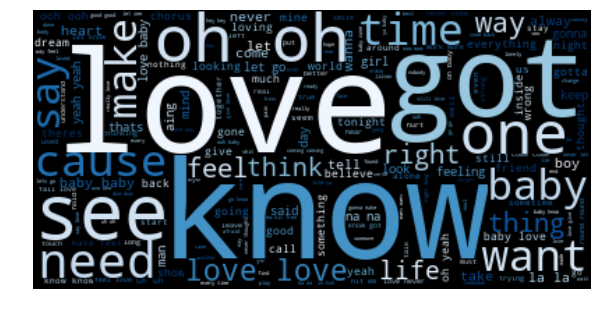

In [177]:
female_corpus_str = [" ".join(d) for d in female_corpus]
female_corpus_str = " ".join(female_corpus_str)
female_corpus_str

wordcloud = WordCloud(colormap="Blues").generate(female_corpus_str)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

love	7224
baby	4272
know	3988
oh	3585
like	2865
got	2365
get	2329
never	2156
want	1994
go	1977
would	1930
make	1894
one	1888
time	1875
yeah	1812
see	1807
come	1781
let	1780
feel	1743
way	1571


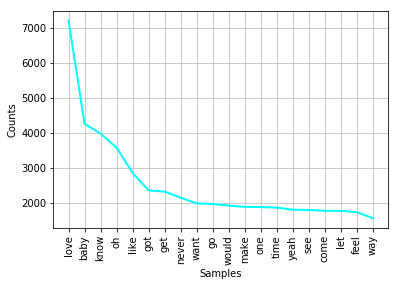

In [178]:
frequency_analysis(female_corpus_str.split(" "))

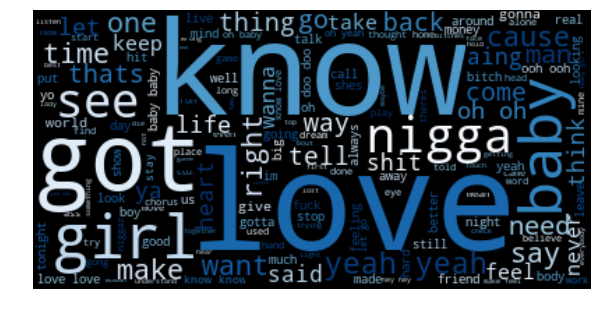

In [179]:
male_corpus_str = [" ".join(d) for d in male_corpus]
male_corpus_str = " ".join(male_corpus_str)
male_corpus_str

wordcloud = WordCloud(colormap="Blues").generate(male_corpus_str)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

love	5806
know	4818
like	4367
baby	4117
yeah	3873
got	3758
get	3408
oh	3177
girl	2958
go	2162
see	2135
wanna	2125
want	2093
one	2044
make	2039
say	1980
come	1975
let	1969
aing	1951
time	1942


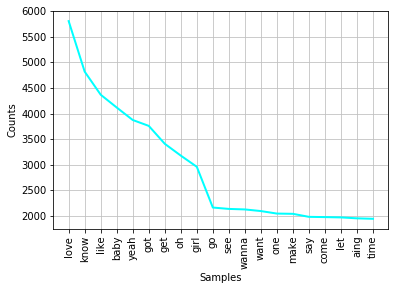

In [180]:
frequency_analysis(male_corpus_str.split(" "))

In [181]:
sentiment_female = [[d.sent, d.sent_score] for d in corpus if d.gender == "female"]
sentiment_male = [[d.sent, d.sent_score] for d in corpus if d.gender == "male"]

In [183]:
#Normalising to a percentage
female_sent_dist = female_sentiments['sentiment'].value_counts(normalize=True) * 100
male_sent_dist = male_sentiments['sentiment'].value_counts(normalize=True) * 100
female_sent_dist.values

array([72.1 , 23.14,  4.76])

In [184]:
combined = pd.DataFrame({"sentiment": ["positive", "negative", "neutral"], "Female": female_sent_dist.values,
                        "Male": male_sent_dist.values})

combined = pd.melt(combined, id_vars="sentiment", var_name="gender", value_name="percentage")
combined

,sentiment,gender,percentage
0,positive,Female,72.10
1,negative,Female,23.14
2,neutral,Female,4.76
3,positive,Male,64.66
4,negative,Male,31.08
5,neutral,Male,4.26


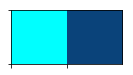

In [185]:
col_list = ["cyan", "twilight blue"]
sns.palplot(sns.xkcd_palette(col_list))
col_list_palette = sns.xkcd_palette(col_list)
sns.set_palette(col_list_palette)

Text(0.5,1,'Overall sentiment polarity of artists')

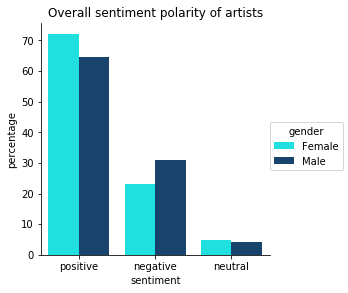

In [186]:
sns.factorplot(x='sentiment', y='percentage', hue='gender', data=combined, kind='bar')
plt.title('Overall sentiment polarity of artists')

### Train Model

In [187]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))

#### Baseline model

In [188]:
baseline_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bow_features', Pipeline([
                ('bow_processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('bow_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer()),
            ])),
             
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', MultinomialNB()),
])

In [189]:
baseline_model_search = GridSearchCV(baseline_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'union__bow_features__norm__use_idf': (True, False),
                            'selector__k': [200, 'all'],
                            'clf': [MultinomialNB()],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         },
                     ])

baseline_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('bow_features', Pipeline(memory=None,
     steps=[('bow_processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x1a7bc107b8>)), ('bow_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=Tru...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'union__bow_features__norm__use_idf': (True, False), 'selector__k': [200, 'all'], 'clf': [MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall

In [190]:
pd.DataFrame(baseline_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__alpha,param_clf__fit_prior,param_selector__k,param_union__bow_features__norm__use_idf,params,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.312029,0.112202,0.243623,0.038527,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,True,200,True,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.011176,27,0.680034,0.708338,0.694415,0.703692,0.681622,0.693620,0.011378,28
1,0.249536,0.019886,0.216278,0.011080,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,True,200,False,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.008506,37,0.682240,0.690776,0.669513,0.685749,0.667611,0.679180,0.009102,37
2,0.282208,0.046441,0.256328,0.037181,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,True,all,True,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.010400,1,0.770722,0.775546,0.755773,0.781967,0.753891,0.767581,0.011017,1
3,0.253648,0.011914,0.214542,0.008360,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,True,all,False,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.006077,14,0.740488,0.747068,0.740431,0.754885,0.735287,0.743631,0.006754,14
4,0.249761,0.006379,0.223576,0.009012,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,False,200,True,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.011784,27,0.679034,0.704154,0.695902,0.709221,0.681792,0.694020,0.011928,25
5,0.238070,0.001245,0.209768,0.002649,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,False,200,False,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.008058,42,0.677040,0.689761,0.668105,0.681092,0.666842,0.676570,0.008497,40
6,0.247906,0.001331,0.215532,0.003216,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,False,all,True,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.010139,2,0.770722,0.774940,0.755172,0.781431,0.754557,0.767366,0.010761,2
7,0.241877,0.004715,0.208997,0.002413,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.5,False,all,False,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.006127,13,0.741206,0.745864,0.743215,0.756834,0.736628,0.744749,0.006753,13
8,0.247623,0.002684,0.214541,0.002099,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.7,True,200,True,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.012011,25,0.679433,0.709545,0.695073,0.705037,0.680898,0.693998,0.012236,26
9,0.239784,0.002817,0.212595,0.006750,"MultinomialNB(alpha=0.5, class_prior=None, fit...",0.7,True,200,False,"{'clf': MultinomialNB(alpha=0.5, class_prior=N...",...,0.006883,38,0.680842,0.688817,0.670230,0.681922,0.669464,0.678257,0.007394,38


In [191]:
baseline_model_search.best_params_

{'clf': MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True),
 'clf__alpha': 0.5,
 'clf__fit_prior': True,
 'selector__k': 'all',
 'union__bow_features__norm__use_idf': True}

In [195]:
optimised_baseline_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bow_features', Pipeline([
                ('bow_processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('bow_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),       
        ],
    )),
    ('selector', SelectKBest(k = 'all')),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=True)),
])


cv_scores = cross_validate(optimised_baseline_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

print("BASELINE MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

BASELINE MODEL AFTER TUNING: 



Accuracy: mean = 77.34%, sd = 1.08%, min = 75.60, max = 78.80
Precision: mean = 78.17%, sd = 1.03%, min = 76.46, max = 79.60
Recall: mean = 77.34%, sd = 1.08%, min = 75.60, max = 78.80
F1: mean = 77.17%, sd = 1.11%, min = 75.40, max = 78.66


#### Model with Lexical features only

In [201]:
lexical_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bigram', Pipeline([
                ('bigram_processor', DocumentProcessor(process_method = get_bigrams)),
                ('bigram_vectorizer', DictVectorizer()),
                 ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('trigram', Pipeline([
                ('trigram_processor', DocumentProcessor(process_method = get_trigrams)),
                ('trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_trigram', Pipeline([
                ('char_trigram_processor', DocumentProcessor(process_method = get_char_trigrams)),
                ('char_trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_fourgram', Pipeline([
                ('char_fourgram_processor', DocumentProcessor(process_method = get_char_fourgrams)),
                ('char_fourgram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', MultinomialNB()),
])

In [212]:
lexical_model_search = GridSearchCV(lexical_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'selector__k': [200, 'all'],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         }
                     ])

lexical_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('bigram', Pipeline(memory=None,
     steps=[('bigram_processor', DocumentProcessor(process_method=<function get_bigrams at 0x1a7bc108c8>)), ('bigram_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'selector__k': [200, 'all'], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
       verbose=0)

In [213]:
pd.DataFrame(lexical_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_selector__k,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,5.239329,0.633780,4.174854,0.445385,0.5,True,200,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.631480,0.653966,...,0.012678,14,0.631183,0.653899,0.668151,0.643446,0.640302,0.647397,0.012665,14
1,4.880774,0.106156,3.929889,0.069177,0.5,True,all,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.838851,0.845097,...,0.008483,2,0.838848,0.845086,0.851244,0.856111,0.832394,0.844736,0.008470,2
2,4.638262,0.077126,3.767371,0.098046,0.5,False,200,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.629606,0.651468,...,0.014322,18,0.629146,0.651468,0.670385,0.639691,0.637030,0.645544,0.014338,19
3,4.981144,0.066847,3.924173,0.062589,0.5,False,all,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.838851,0.845097,...,0.008402,1,0.838848,0.845086,0.851868,0.856111,0.833018,0.844986,0.008389,1
4,4.584901,0.054762,3.728499,0.080462,0.7,True,200,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.631480,0.655215,...,0.012780,13,0.631183,0.655160,0.668151,0.643975,0.640287,0.647751,0.012772,13
5,4.971709,0.036968,3.904808,0.030612,0.7,True,all,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.834478,0.842598,...,0.009945,3,0.834465,0.842559,0.847454,0.852299,0.824224,0.840200,0.009924,3
6,4.592318,0.081580,3.696088,0.051587,0.7,False,200,"{'clf__alpha': 0.7, 'clf__fit_prior': False, '...",0.628982,0.651468,...,0.014001,20,0.628470,0.651468,0.669044,0.639099,0.637667,0.645150,0.014013,20
7,4.898517,0.119915,3.850811,0.044686,0.7,False,all,"{'clf__alpha': 0.7, 'clf__fit_prior': False, '...",0.833854,0.842598,...,0.010020,4,0.833839,0.842559,0.847454,0.852299,0.824224,0.840075,0.009999,4
8,4.604825,0.076824,3.724195,0.070213,0.9,True,200,"{'clf__alpha': 0.9, 'clf__fit_prior': True, 's...",0.631480,0.653342,...,0.012596,15,0.631183,0.653268,0.667433,0.642784,0.639036,0.646741,0.012554,15
9,4.901922,0.104297,3.924846,0.032092,0.9,True,all,"{'clf__alpha': 0.9, 'clf__fit_prior': True, 's...",0.825734,0.838226,...,0.009315,5,0.825663,0.838151,0.844263,0.843436,0.821671,0.834637,0.009284,5


In [214]:
lexical_model_search.best_params_

{'clf__alpha': 0.5, 'clf__fit_prior': False, 'selector__k': 'all'}

In [215]:
optimised_lexical_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bigram', Pipeline([
                ('bigram_processor', DocumentProcessor(process_method = get_bigrams)),
                ('bigram_vectorizer', DictVectorizer()),
                 ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('trigram', Pipeline([
                ('trigram_processor', DocumentProcessor(process_method = get_trigrams)),
                ('trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_trigram', Pipeline([
                ('char_trigram_processor', DocumentProcessor(process_method = get_char_trigrams)),
                ('char_trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_fourgram', Pipeline([
                ('char_fourgram_processor', DocumentProcessor(process_method = get_char_fourgrams)),
                ('char_fourgram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
        ],
    )),
    ('selector', SelectKBest(k = 'all')),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=False)),
])

lm_cv_scores = cross_validate(optimised_lexical_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("LEXICAL MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", lm_cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", lm_cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", lm_cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", lm_cv_scores['test_f1_weighted'])

LEXICAL MODEL AFTER TUNING: 



Accuracy: mean = 86.06%, sd = 0.83%, min = 84.60, max = 87.30
Precision: mean = 86.09%, sd = 0.84%, min = 84.62, max = 87.35
Recall: mean = 86.06%, sd = 0.83%, min = 84.60, max = 87.30
F1: mean = 86.06%, sd = 0.83%, min = 84.60, max = 87.30


#### Model with Syntactic features only

In [217]:
syntatic_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer()),
            ])),
            ('adj_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_adj_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer()),
            ])),
            ('pp_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pp_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer()),
            ])),
            ('vb_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_vb_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB()),
])

In [208]:
syntatic_model_search = GridSearchCV(syntatic_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'union__pos_features__norm__use_idf': (True, False),
                            'union__adj_fql__norm__use_idf': (True, False),
                            'union__pp_fql__norm__use_idf': (True, False),
                            'union__vb_fql__norm__use_idf': (True, False),
                            'selector__k': [20, 'all'],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         }
                     ])

syntatic_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('pos_features', Pipeline(memory=None,
     steps=[('pos_processor', DocumentProcessor(process_method=<function get_pos_fql at 0x1a7bc10bf8>)), ('pos_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'union__pos_features__norm__use_idf': (True, False), 'union__adj_fql__norm__use_idf': (True, False), 'union__pp_fql__norm__use_idf': (True, False), 'union__vb_fql__norm__use_idf': (True, False), 'selector__k': [20, 'all'], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_trai

In [209]:
pd.DataFrame(syntatic_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_selector__k,param_union__adj_fql__norm__use_idf,param_union__pos_features__norm__use_idf,param_union__pp_fql__norm__use_idf,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.169542,0.109897,0.120483,0.012314,0.5,True,20,True,True,True,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145
1,0.113833,0.006366,0.109863,0.009234,0.5,True,20,True,True,True,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145
2,0.116964,0.011807,0.109347,0.006069,0.5,True,20,True,True,False,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145
3,0.121211,0.021573,0.116653,0.017526,0.5,True,20,True,True,False,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145
4,0.139013,0.016031,0.144044,0.023041,0.5,True,20,True,False,True,...,0.011140,305,0.517705,0.551403,0.543514,0.552470,0.514036,0.535826,0.016624,313
5,0.108358,0.005390,0.103046,0.005148,0.5,True,20,True,False,True,...,0.011140,305,0.517705,0.551403,0.543514,0.552470,0.514036,0.535826,0.016624,313
6,0.104257,0.000428,0.101640,0.001463,0.5,True,20,True,False,False,...,0.011140,305,0.517705,0.551403,0.543514,0.552470,0.514036,0.535826,0.016624,313
7,0.104809,0.001259,0.100634,0.001071,0.5,True,20,True,False,False,...,0.011140,305,0.517705,0.551403,0.543514,0.552470,0.514036,0.535826,0.016624,313
8,0.107454,0.000672,0.103043,0.000419,0.5,True,20,False,True,True,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145
9,0.107191,0.000556,0.102900,0.000603,0.5,True,20,False,True,True,...,0.005005,217,0.546801,0.566015,0.554283,0.556005,0.546619,0.553946,0.007139,145


In [210]:
syntatic_model_search.best_params_

{'clf__alpha': 1.5,
 'clf__fit_prior': False,
 'selector__k': 'all',
 'union__adj_fql__norm__use_idf': True,
 'union__pos_features__norm__use_idf': True,
 'union__pp_fql__norm__use_idf': True,
 'union__vb_fql__norm__use_idf': True}

In [220]:
optimised_syntatic_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),             
            ])),
            ('adj_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_adj_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pp_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pp_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('vb_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_vb_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
        ],
    )),
    ('clf', MultinomialNB(alpha=1.5, fit_prior=False)),
])

In [221]:
sym_cv_scores = cross_validate(optimised_syntatic_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("SYNTATIC MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", sym_cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", sym_cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", sym_cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", sym_cv_scores['test_f1_weighted'])

SYNTATIC MODEL AFTER TUNING: 



Accuracy: mean = 56.96%, sd = 1.08%, min = 54.90, max = 58.50
Precision: mean = 57.27%, sd = 1.17%, min = 55.04, max = 58.97
Recall: mean = 56.96%, sd = 1.08%, min = 54.90, max = 58.50
F1: mean = 56.51%, sd = 1.03%, min = 54.59, max = 57.96


#### Model with sentiment features

In [222]:
sentiment_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pws_features', Pipeline([
                ('pws_processor', DocumentProcessor(process_method = get_pws_fql)),
                ('pws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_features', Pipeline([
                ('nws_processor', DocumentProcessor(process_method = get_nws_fql)),
                ('nws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('pws_stat', Pipeline([
                ('pwstat_processor', DocumentProcessor(process_method = get_pws_stats)),
                ('pwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_stat', Pipeline([
                ('nwstat_processor', DocumentProcessor(process_method = get_nws_stats)),
                ('nwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('sent_score', Pipeline([
                ('sent_score_processor', DocumentProcessor(process_method = get_overall_polarity)),
                ('sent_score_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
        ],
    )),
    ('selector', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB()),
])

In [238]:
sentiment_model_search = GridSearchCV(sentiment_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'union__sent_score__norm__use_idf': (True, False),
                            'selector__k': [200, 'all'],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         }
                     ])

sentiment_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('pws_features', Pipeline(memory=None,
     steps=[('pws_processor', DocumentProcessor(process_method=<function get_pws_fql at 0x1a7961a378>)), ('pws_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'union__sent_score__norm__use_idf': (True, False), 'selector__k': [200, 'all'], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
       verbose=0)

In [239]:
pd.DataFrame(sentiment_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_selector__k,param_union__sent_score__norm__use_idf,params,split0_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,27.800096,0.222284,28.084767,0.255399,0.5,True,200,True,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.644597,...,0.005249,29,0.640943,0.644144,0.637055,0.629954,0.634008,0.637224,0.004999,29
1,28.627261,1.573214,28.667108,0.837956,0.5,True,200,False,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.644597,...,0.005249,29,0.640943,0.644144,0.637055,0.629954,0.634008,0.637224,0.004999,29
2,49.924497,40.948401,79.261936,62.786805,0.5,True,all,True,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.687071,...,0.003131,1,0.685074,0.678522,0.680501,0.683141,0.687034,0.682853,0.003059,1
3,30.650248,2.227768,30.909479,3.255146,0.5,True,all,False,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.687071,...,0.003131,1,0.685074,0.678522,0.680501,0.683141,0.687034,0.682853,0.003059,1
4,28.504480,0.252270,29.070989,0.483384,0.5,False,200,True,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.643973,...,0.005914,39,0.640358,0.643821,0.635986,0.627654,0.632958,0.636158,0.005638,39
5,29.050690,0.367545,28.720129,0.493161,0.5,False,200,False,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.643973,...,0.005914,39,0.640358,0.643821,0.635986,0.627654,0.632958,0.636158,0.005638,39
6,28.659495,0.409736,29.250098,0.912813,0.5,False,all,True,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.684572,...,0.004557,3,0.682684,0.676338,0.679979,0.684527,0.689844,0.682673,0.004522,3
7,30.519902,3.091251,29.516549,1.509728,0.5,False,all,False,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.684572,...,0.004557,3,0.682684,0.676338,0.679979,0.684527,0.689844,0.682673,0.004522,3
8,30.218765,0.740332,30.047990,0.278626,0.7,True,200,True,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.644597,...,0.005373,25,0.640943,0.644819,0.637055,0.629954,0.634476,0.637452,0.005132,25
9,29.753753,1.962403,29.165249,0.931143,0.7,True,200,False,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.644597,...,0.005373,25,0.640943,0.644819,0.637055,0.629954,0.634476,0.637452,0.005132,25


In [240]:
sentiment_model_search.best_params_

{'clf__alpha': 0.5,
 'clf__fit_prior': True,
 'selector__k': 'all',
 'union__sent_score__norm__use_idf': True}

In [244]:
optimised_sentiment_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pws_features', Pipeline([
                ('pws_processor', DocumentProcessor(process_method = get_pws_fql)),
                ('pws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_features', Pipeline([
                ('nws_processor', DocumentProcessor(process_method = get_nws_fql)),
                ('nws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('pws_stat', Pipeline([
                ('pwstat_processor', DocumentProcessor(process_method = get_pws_stats)),
                ('pwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_stat', Pipeline([
                ('nwstat_processor', DocumentProcessor(process_method = get_nws_stats)),
                ('nwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('sent_score', Pipeline([
                ('sent_score_processor', DocumentProcessor(process_method = get_overall_polarity)),
                ('sent_score_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
        ],
    )),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=True)),
])

In [245]:
sen_cv_scores = cross_validate(optimised_sentiment_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("SENTIMENT MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", sen_cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", sen_cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", sen_cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", sen_cv_scores['test_f1_weighted'])

SENTIMENT MODEL AFTER TUNING: 



Accuracy: mean = 69.01%, sd = 1.46%, min = 66.00, max = 71.20
Precision: mean = 69.55%, sd = 1.49%, min = 66.32, max = 72.16
Recall: mean = 69.01%, sd = 1.46%, min = 66.00, max = 71.20
F1: mean = 68.80%, sd = 1.48%, min = 65.83, max = 70.89


#### Model with semantic features

In [224]:
semantic_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('word_emb', Pipeline([
                ('processor', DocumentProcessor(process_method = get_word_emb)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer())
            ])),

        ],
    )),
    ('selector', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB()),
])

In [225]:
semantic_model_search = GridSearchCV(semantic_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'union__word_emb__norm__use_idf': (True, False),
                            'selector__k': [200, 'all'],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         }
                     ])

semantic_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('word_emb', Pipeline(memory=None,
     steps=[('processor', DocumentProcessor(process_method=<function get_word_emb at 0x1a7bc10ea0>)), ('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        spa...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'union__word_emb__norm__use_idf': (True, False), 'selector__k': [200, 'all'], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
       verbose=0)

In [226]:
pd.DataFrame(semantic_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_selector__k,param_union__word_emb__norm__use_idf,params,split0_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,3.290410,0.297667,3.131934,0.310302,0.5,True,200,True,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.687071,...,0.009590,29,0.683690,0.693609,0.671044,0.700064,0.680565,0.685794,0.010138,34
1,3.032547,0.021230,3.087294,0.186112,0.5,True,200,False,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.680200,...,0.007032,37,0.678127,0.676387,0.666933,0.687775,0.670728,0.675989,0.007116,37
2,3.023068,0.018465,2.992981,0.024306,0.5,True,all,True,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.755153,...,0.006285,2,0.752410,0.762221,0.756114,0.765934,0.746522,0.756641,0.006899,2
3,3.020182,0.021595,2.998177,0.025359,0.5,True,all,False,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.737039,...,0.006911,14,0.733382,0.747082,0.728166,0.743171,0.729103,0.736182,0.007614,14
4,3.038617,0.024156,2.997518,0.025902,0.5,False,200,True,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.692067,...,0.010049,34,0.690284,0.690700,0.669199,0.698997,0.680634,0.685963,0.010201,31
5,3.015751,0.008596,2.992295,0.021188,0.5,False,200,False,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.680200,...,0.007649,41,0.678439,0.675546,0.664695,0.687323,0.669798,0.675160,0.007707,40
6,3.035543,0.009148,2.993603,0.027998,0.5,False,all,True,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.755778,...,0.006731,1,0.753139,0.762221,0.756185,0.767908,0.746602,0.757211,0.007343,1
7,3.002922,0.009775,3.000428,0.031425,0.5,False,all,False,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.738289,...,0.007509,13,0.734804,0.747749,0.727069,0.743838,0.728513,0.736396,0.008197,13
8,3.024971,0.021177,2.982807,0.041832,0.7,True,200,True,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.685197,...,0.008537,32,0.681920,0.692312,0.672812,0.698804,0.681160,0.685401,0.009120,35
9,3.033642,0.029118,2.980773,0.034429,0.7,True,200,False,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.681449,...,0.007903,38,0.679252,0.675419,0.666861,0.688963,0.667938,0.675687,0.008085,39


In [227]:
semantic_model_search.best_params_

{'clf__alpha': 0.5,
 'clf__fit_prior': False,
 'selector__k': 'all',
 'union__word_emb__norm__use_idf': True}

In [228]:
optimised_semantic_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('word_emb', Pipeline([
                ('processor', DocumentProcessor(process_method = get_word_emb)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True))
            ])),

        ],
    )),
    ('selector', SelectKBest(k='all')),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=False)),
])

In [229]:
sem_cv_scores = cross_validate(optimised_semantic_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("SEMANTIC MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", sem_cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", sem_cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", sem_cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", sem_cv_scores['test_f1_weighted'])

SEMANTIC MODEL AFTER TUNING: 



Accuracy: mean = 77.37%, sd = 1.23%, min = 75.80, max = 80.30
Precision: mean = 78.46%, sd = 1.15%, min = 77.11, max = 81.20
Recall: mean = 77.37%, sd = 1.23%, min = 75.80, max = 80.30
F1: mean = 77.15%, sd = 1.26%, min = 75.50, max = 80.16


#### Model with all features

In [230]:
combined_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bow_features', Pipeline([
                ('bow_processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('bow_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('bigram', Pipeline([
                ('bigram_processor', DocumentProcessor(process_method = get_bigrams)),
                ('bigram_vectorizer', DictVectorizer()),
                 ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('trigram', Pipeline([
                ('trigram_processor', DocumentProcessor(process_method = get_trigrams)),
                ('trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_trigram', Pipeline([
                ('char_trigram_processor', DocumentProcessor(process_method = get_char_trigrams)),
                ('char_trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_fourgram', Pipeline([
                ('char_fourgram_processor', DocumentProcessor(process_method = get_char_fourgrams)),
                ('char_fourgram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),   
            ])),
            ('adj_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_adj_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pp_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pp_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('vb_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_vb_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pws_features', Pipeline([
                ('pws_processor', DocumentProcessor(process_method = get_pws_fql)),
                ('pws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_features', Pipeline([
                ('nws_processor', DocumentProcessor(process_method = get_nws_fql)),
                ('nws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('pws_stat', Pipeline([
                ('pwstat_processor', DocumentProcessor(process_method = get_pws_stats)),
                ('pwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_stat', Pipeline([
                ('nwstat_processor', DocumentProcessor(process_method = get_nws_stats)),
                ('nwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('sent_score', Pipeline([
                ('sent_score_processor', DocumentProcessor(process_method = get_overall_polarity)),
                ('sent_score_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),  
            ('word_emb', Pipeline([
                ('processor', DocumentProcessor(process_method = get_word_emb)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer())
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB()),
])

In [231]:
combined_model_search = GridSearchCV(combined_model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted", 
                     param_grid = [
                         {
                            'selector__k': [200, 'all'],
                            'clf__alpha': np.linspace(0.5, 1.5, 6),
                            'clf__fit_prior': [True, False], 
                         }
                     ])

combined_model_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('bow_features', Pipeline(memory=None,
     steps=[('bow_processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x1a7bc107b8>)), ('bow_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=Tru...unction chi2 at 0x107d7aae8>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'selector__k': [200, 'all'], 'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]), 'clf__fit_prior': [True, False]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
       verbose=0)

In [232]:
pd.DataFrame(combined_model_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_selector__k,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,37.199901,1.957009,35.470991,0.239638,0.5,True,200,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.675203,0.677701,...,0.005344,13,0.672535,0.674091,0.658646,0.670265,0.672077,0.669523,0.005574,13
1,36.633011,0.071944,35.562050,0.067659,0.5,True,all,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 's...",0.830106,0.833229,...,0.002606,1,0.830028,0.833157,0.832373,0.838022,0.832277,0.833171,0.002640,1
2,37.727947,2.175498,39.796712,7.533287,0.5,False,200,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.674578,0.677077,...,0.005523,16,0.672231,0.673588,0.657653,0.669152,0.671060,0.668738,0.005730,15
3,41.611982,3.451590,38.216359,1.369258,0.5,False,all,"{'clf__alpha': 0.5, 'clf__fit_prior': False, '...",0.830106,0.833229,...,0.002606,1,0.830028,0.833157,0.832373,0.838022,0.832277,0.833171,0.002640,1
4,40.017623,4.123420,38.009117,2.464546,0.7,True,200,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.674578,0.677077,...,0.005904,14,0.671943,0.673416,0.656796,0.670190,0.672077,0.668885,0.006131,14
5,36.636487,0.177561,35.825694,0.564384,0.7,True,all,"{'clf__alpha': 0.7, 'clf__fit_prior': True, 's...",0.824485,0.831980,...,0.003380,4,0.824408,0.831931,0.829311,0.832390,0.824800,0.828568,0.003405,4
6,36.132759,0.235996,35.210686,0.061048,0.7,False,200,"{'clf__alpha': 0.7, 'clf__fit_prior': False, '...",0.674578,0.676452,...,0.005407,17,0.672160,0.672914,0.657741,0.669152,0.670979,0.668590,0.005571,17
7,36.641725,0.210760,35.551240,0.206425,0.7,False,all,"{'clf__alpha': 0.7, 'clf__fit_prior': False, '...",0.824485,0.831980,...,0.003526,3,0.824408,0.831931,0.829311,0.833014,0.824800,0.828693,0.003551,3
8,36.196929,0.216901,35.375019,0.093793,0.9,True,200,"{'clf__alpha': 0.9, 'clf__fit_prior': True, 's...",0.672705,0.677077,...,0.004987,15,0.670164,0.673416,0.658737,0.669521,0.671403,0.668649,0.005131,16
9,36.415576,0.046868,35.352351,0.071312,0.9,True,all,"{'clf__alpha': 0.9, 'clf__fit_prior': True, 's...",0.817614,0.825109,...,0.005296,6,0.817548,0.825086,0.823733,0.832994,0.819838,0.823839,0.005309,6


In [233]:
combined_model_search.best_params_

{'clf__alpha': 0.5, 'clf__fit_prior': True, 'selector__k': 'all'}

In [236]:
optimised_combined_model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bow_features', Pipeline([
                ('bow_processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('bow_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('bigram', Pipeline([
                ('bigram_processor', DocumentProcessor(process_method = get_bigrams)),
                ('bigram_vectorizer', DictVectorizer()),
                 ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('trigram', Pipeline([
                ('trigram_processor', DocumentProcessor(process_method = get_trigrams)),
                ('trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_trigram', Pipeline([
                ('char_trigram_processor', DocumentProcessor(process_method = get_char_trigrams)),
                ('char_trigram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('char_fourgram', Pipeline([
                ('char_fourgram_processor', DocumentProcessor(process_method = get_char_fourgrams)),
                ('char_fourgram_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),   
            ])),
            ('adj_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_adj_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pp_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pp_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('vb_fql', Pipeline([
                ('processor', DocumentProcessor(process_method = get_vb_fql)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('pws_features', Pipeline([
                ('pws_processor', DocumentProcessor(process_method = get_pws_fql)),
                ('pws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_features', Pipeline([
                ('nws_processor', DocumentProcessor(process_method = get_nws_fql)),
                ('nws_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])), 
            ('pws_stat', Pipeline([
                ('pwstat_processor', DocumentProcessor(process_method = get_pws_stats)),
                ('pwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('nws_stat', Pipeline([
                ('nwstat_processor', DocumentProcessor(process_method = get_nws_stats)),
                ('nwstat_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),
            ('sent_score', Pipeline([
                ('sent_score_processor', DocumentProcessor(process_method = get_overall_polarity)),
                ('sent_score_vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer(use_idf=True)),
            ])),  
            ('word_emb', Pipeline([
                ('processor', DocumentProcessor(process_method = get_word_emb)),
                ('vectorizer', DictVectorizer()),
                ('norm', TfidfTransformer())
            ])),
        ],
    )),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=False)),
])

In [237]:
cmb_cv_scores = cross_validate(optimised_combined_model, X, y, cv=StratifiedKFold(n_splits=10, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("COMBINE MODEL AFTER TUNING: \n\n\n")
print_cv_scores_summary("Accuracy", cmb_cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cmb_cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cmb_cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cmb_cv_scores['test_f1_weighted'])

COMBINE MODEL AFTER TUNING: 



Accuracy: mean = 84.91%, sd = 0.89%, min = 82.90, max = 86.50
Precision: mean = 84.95%, sd = 0.89%, min = 82.92, max = 86.50
Recall: mean = 84.91%, sd = 0.89%, min = 82.90, max = 86.50
F1: mean = 84.91%, sd = 0.89%, min = 82.90, max = 86.50
